In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploads = files.upload()

# Data Read

In [ ]:
import csv

# Specify the file path
file_path = "scraped_data.csv"

# List to store the parsed data
scraped_data_list = []

# Read the data from the CSV file
with open(file_path, mode='r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        # Assuming each row contains only one object
        scraped_data_list.append(row[0])

In [4]:

dfs = []
for scraped_data in scraped_data_list:
  # print(scraped_data)
  scraped_data_lines = scraped_data.split("\n")
  data_values = [line.split('|') for line in scraped_data_lines]
  columns = data_values[0]
  # print(data_values[2])
  df = pd.DataFrame(data_values[1:], columns=columns)

  # print(df.head())
  dfs.append(df)


In [ ]:
dfs = []
majority_sepsis_labels = []

for scraped_data in scraped_data_list:
    scraped_data_lines = scraped_data.split("\n")
    data_values = [line.split('|') for line in scraped_data_lines]
    columns = data_values[0]
    df = pd.DataFrame(data_values[1:], columns=columns)

    # Convert 'SepsisLabel' to numeric
    df['SepsisLabel'] = pd.to_numeric(df['SepsisLabel'])

    # Extract first 49 rows
    first_49_rows = df.head(49)

    # Calculate majority SepsisLabel value
    majority_sepsis_label = first_49_rows['SepsisLabel'].mode().iloc[0]

    dfs.append(df)
    majority_sepsis_labels.append(majority_sepsis_label)

# Data Preprocess

In [ ]:
import numpy as np

updated_dfs = []
basic_data = []
parameters_size = 41
times_threshold = 49
max_times = 0

for df in dfs:
    value_array = []
    delta_array = []
    mask_array = []
    dataset = []

    last_available_times = np.zeros(parameters_size)
    count = 0

    for index, row in df.iterrows():
        count += 1
        values = row.values
        # Replace 'NaN' strings with 0 and convert to float
        values = [0 if str(val) == 'NaN' else float(val) for val in values]

        deltas = np.zeros(parameters_size)
        mask = np.zeros(parameters_size)

        for i, value in enumerate(values):
            if not np.isnan(value):
                mask[i] = 1
                last_available_times[i] = count

        for i in range(parameters_size):
            deltas[i] = count - last_available_times[i]

        value_array.append(values)
        delta_array.append(deltas)
        mask_array.append(mask)

        if count == times_threshold:
          break

    # Pad arrays if count is less than times_threshold
    while count < times_threshold:
        value_array.append(np.zeros(parameters_size))
        delta_array.append(np.zeros(parameters_size))
        mask_array.append(np.zeros(parameters_size))
        count += 1

    value_array = np.array(value_array).T
    delta_array = np.array(delta_array).T
    mask_array = np.array(mask_array).T

    dataset.append(value_array)
    dataset.append(mask_array)
    dataset.append(delta_array)
    updated_dfs.append(dataset)
    basic_data.append(value_array)

    max_times = max(max_times, count)

print("Max Time Groups:", max_times)


# Data split and loader

In [ ]:
import numpy as np

def custom_train_test_split(features, labels, test_size, validation_size=0.2, random_state=None):
  if random_state is not None:
    np.random.seed(random_state)

  # Shuffle indices
  indices = np.arange(len(features))
  np.random.shuffle(indices)

  # Calculate the number of test and validation samples
  n_test = int(len(features) * test_size)
  n_validation = int(len(features) * validation_size)

  # Split indices into test, validation, and train sets
  test_indices = indices[:n_test]
  validation_indices = indices[n_test:n_test + n_validation]
  train_indices = indices[n_test + n_validation:]

  # Split data based on indices
  test_data = [features[i] for i in test_indices]
  validation_data = [features[i] for i in validation_indices]
  train_data = [features[i] for i in train_indices]

  # Split labels based on indices
  test_labels = [labels['labels'].iloc[i] for i in test_indices]
  validation_labels = [labels['labels'].iloc[i] for i in validation_indices]
  train_labels = [labels['labels'].iloc[i] for i in train_indices]

  return train_data, train_labels, validation_data, validation_labels, test_data, test_labels

In [ ]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
  def __init__(self, features, labels) -> None:
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    sample = self.features[index]
    label = self.labels[index]
    sample = torch.tensor(sample, dtype=torch.float32)
    label = torch.tensor(label, dtype = torch.float32)
    return sample, label

In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

def get_data_loader(dataset, labels_df):
  train_features, train_labels, validation_features, validation_labels, test_features, test_labels = custom_train_test_split(dataset, labels_df, test_size=0.2, validation_size = 0.15)

  train_dataset = CustomDataset(train_features, train_labels)
  validation_dataset = CustomDataset(validation_features, validation_labels)
  test_dataset = CustomDataset(test_features, test_labels)

  train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
  validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle = True)
  test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

  return train_loader, validation_loader, test_loader

In [ ]:
grud_train_loader, grud_val_loader, grud_test_loader = get_data_loader(updated_dfs, majority_sepsis_labels)

#GRUD Model

In [ ]:
import torch.nn as nn
import math

class GRUD(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, x_mean, bias, batch_first=True, bidirectional=False,  dropout_type=None, dropout=0, static=False):
    super(GRUD, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.n_times = times_threshold
    self.bias = bias
    self.bidirectional = bidirectional
    self.dropout_type = dropout_type
    self.dropout= dropout
    self._all_weights = []
    self.zeros = torch.autograd.Variable(torch.zeros(input_size))
    self.x_mean = x_mean

    # decay rates gamma
    w_dg_x = torch.nn.Parameter(torch.Tensor(input_size))
    w_dg_h = torch.nn.Parameter(torch.Tensor(hidden_size))
    # z
    w_xz = torch.nn.Parameter(torch.Tensor(input_size))
    w_hz = torch.nn.Parameter(torch.Tensor(hidden_size))
    w_mz = torch.nn.Parameter(torch.Tensor(input_size))
    # r
    w_xr = torch.nn.Parameter(torch.Tensor(input_size))
    w_hr = torch.nn.Parameter(torch.Tensor(hidden_size))
    w_mr = torch.nn.Parameter(torch.Tensor(input_size))
    # h_tilde
    w_xh = torch.nn.Parameter(torch.Tensor(input_size))
    w_hh = torch.nn.Parameter(torch.Tensor(hidden_size))
    w_mh = torch.nn.Parameter(torch.Tensor(input_size))
    # y (output)
    w_hy = torch.nn.Parameter(torch.Tensor(output_size, hidden_size))
    # bias
    b_dg_x = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_dg_h = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_z = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_r = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_h = torch.nn.Parameter(torch.Tensor(hidden_size))
    b_y = torch.nn.Parameter(torch.Tensor(output_size))
    # layer params
    layer_params = (w_dg_x, w_dg_h,
                    w_xz, w_hz, w_mz,
                    w_xr, w_hr, w_mr,
                    w_xh, w_hh, w_mh,
                    w_hy,
                    b_dg_x, b_dg_h, b_z, b_r, b_h, b_y)
    param_names = ['weight_dg_x', 'weight_dg_h',
                    'weight_xz', 'weight_hz', 'weight_mz',
                    'weight_xr', 'weight_hr', 'weight_mr',
                    'weight_xh', 'weight_hh', 'weight_mh',
                    'weight_hy']
    if bias:
      param_names += ['bias_dg_x', 'bias_dg_h',
                      'bias_z',
                      'bias_r',
                      'bias_h',
                      'bias_y']
    for name, param in zip(param_names, layer_params):
      setattr(self, name, param)
    self._all_weights.append(param_names)
    self.reset_parameters()
    return

  def forward(self, input):
    # input1 = torch.squeeze(input)
    X = input[:, 0, :, :]
    Delta = input[:, 1, :, :]
    Mask = input[:, 2, :, :]
    hidden_states = []
    batch_size = 16
    n_times = 49
    h = torch.zeros(batch_size, self.hidden_size)
    # Hidden_State = torch.autograd.Variable(torch.zeros(self.input_size))
    # print(input1.size())
    output = None
    # decay rates gamma
    w_dg_x = getattr(self, 'weight_dg_x')
    w_dg_h = getattr(self, 'weight_dg_h')

    # z
    w_xz = getattr(self, 'weight_xz')
    w_hz = getattr(self, 'weight_hz')
    w_mz = getattr(self, 'weight_mz')

    # r
    w_xr = getattr(self, 'weight_xr')
    w_hr = getattr(self, 'weight_hr')
    w_mr = getattr(self, 'weight_mr')

    # h_tilde
    w_xh = getattr(self, 'weight_xh')
    w_hh = getattr(self, 'weight_hh')
    w_mh = getattr(self, 'weight_mh')
    # bias
    b_dg_x = getattr(self, 'bias_dg_x')
    b_dg_h = getattr(self, 'bias_dg_h')
    b_z = getattr(self, 'bias_z')
    b_r = getattr(self, 'bias_r')
    b_h = getattr(self, 'bias_h')

    for n_time in range(self.n_times):
      x = torch.squeeze(X[:, :, n_time:n_time+1])
      d = torch.squeeze(Delta[:, :, n_time:n_time+1])
      m = torch.squeeze(Mask[:, :, n_time:n_time+1])

      # print(d.size())
      # print(w_dg_x.size())
      # print(b_dg_x.size())
      gamma_x = torch.exp(-torch.max(self.zeros, (w_dg_x *d + b_dg_x)))
      # print("Gamma")
      # print(gamma_x.size())
      gamma_h = torch.exp(-torch.max(self.zeros, (d * w_dg_h.T + b_dg_h)))

      x = m * x + (1 - m) * (gamma_x * x + (1 - gamma_x) * self.x_mean)

      h = gamma_h * h
      z = torch.sigmoid((w_xz * x + w_hz * h + w_mz * m + b_z))
      r = torch.sigmoid((w_xr * x + w_hr * h + w_mr * m + b_r))
      h_tilde = torch.tanh((w_xh * x + w_hh * (r * h) + w_mh * m + b_h))
      h = (1 - z) * h + z * h_tilde
      hidden_states.append(h.unsqueeze(1))

    w_hy = getattr(self, 'weight_hy')
    b_y = getattr(self, 'bias_y')
    hidden_states = torch.cat(hidden_states, dim=1)  # shape: [batch_size, seq_length, hidden_size]
    # output = torch.matmul(h, w_hy.view(input_size, 1)) + b_y
    return hidden_states

  def reset_parameters(self):
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      torch.nn.init.uniform_(weight, -stdv, stdv)

In [ ]:
class MyGRUDModel(nn.Module):
  def __init__(self):
    super(MyGRUDModel, self).__init__()
    self.grud = GRUD(input_size=41, hidden_size=41, output_size=5, num_layers=1, x_mean=torch.rand(41), bias=True)
    self.gru = nn.GRU(input_size=41, hidden_size=15, num_layers=2, batch_first=True)
    self.fc = nn.Linear(15, 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    hidden_states = self.grud(x)
    out, _ = self.gru(hidden_states)
    out = out[:, -1, :]
    out = self.fc(out)
    out = self.relu(out)
    return out

# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

input_size = 41  # Placeholder for actual unique parameters count
hidden_size = 41
output_size = 1
num_layers = times_threshold  # Placeholder for the times_threshold value
x_mean = torch.tensor(0.0)  # Placeholder for the actual mean of your data
bias = True
batch_first = True
bidirectional = False
dropout_type = ""
dropout = 0
static = True
lr = 0.01
momentum = 0.9
gamma = 0.1

# Define the model (assuming the model class is correctly defined as MyGRUDModel)
model = MyGRUDModel()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)  # Reduce LR by gamma factor every epoch
loss_function = nn.BCEWithLogitsLoss()

num_epochs = 10

def train_model(train_loader, validation_loader):
    for n_epoch in range(num_epochs):
        total_train_loss = 0.0
        total_val_loss = 0.0
        model.train()  # Set the model to training mode

        # Training phase
        for inputs, labels in train_loader:
            # print(inputs.size())
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            labels = labels.float().view(-1)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = model(inputs).squeeze()
                labels = labels.float().view(-1)
                loss = loss_function(outputs, labels)
                total_val_loss += loss.item() * inputs.size(0)

        # Calculate average losses
        train_loss = total_train_loss / len(train_loader.dataset)
        val_loss = total_val_loss / len(validation_loader.dataset)

        print(f"Epoch {n_epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Assuming grud_train_loader and grud_validation_loader are defined
train_model(grud_train_loader, grud_val_loader)


# Test Model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import torch

def gru_test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_probabilities = []  # Store probabilities for AUROC plotting

    with torch.no_grad():  # Disable gradient computation during inference
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()  # Ensure output is a 1D tensor
            labels = labels.float().view(-1)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities < 0.5).float()  # Convert logits to binary predictions (0 or 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)  # Increment total samples processed
            all_labels.extend(labels.tolist())
            all_probabilities.extend(probabilities.tolist())  # Use probabilities for ROC calculation

    accuracy = correct_predictions / total_samples
    auroc_score = roc_auc_score(all_labels, all_probabilities)  # Notice change here for probabilities
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"AUROC Score: {auroc_score:.4f}")

    # Generate classification report
    binary_predictions = [1 if prob < 0.5 else 0 for prob in all_probabilities]
    report = classification_report(all_labels, binary_predictions, target_names=['Class 0', 'Class 1'])
    print("Classification Report:\n", report)

    # Compute ROC curve and ROC area for plotting
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# You would call gru_test_model with your model and DataLoader instance.


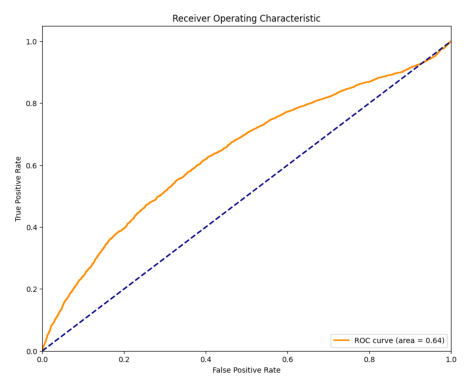

In [5]:
gru_test_model(model, grud_test_loader)